In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import maxflow


def display_image(window_name, img, window_1_name=None, img_1=None):
    """
    Displays image with given window name.
    :param window_name: name of the window
    :param img: image object to display
    """
    if window_1_name is not None and img_1 is not None:
        plt.figure(figsize=(15, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap="gray")
        plt.title(window_name)
        plt.subplot(1, 2, 2)
        plt.imshow(img_1, cmap="gray")
        plt.title(window_1_name)
    else:
        plt.imshow(img, cmap="gray")
        plt.title(window_name)
        plt.show()

## Task 3.
Denoise the binary image using a Markov random field.  For cut, use max-flow/min-cutalgorithm.  Read a noisy binary imagenoise.png

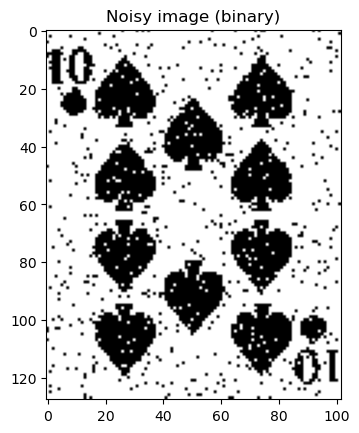

Noisy Img shape: (128, 102)
Noisy Img dtype: uint8


In [2]:
# set image path
img_path = './images/noise.png'
# read imgs
noisy_img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
display_image('Noisy image (binary)', noisy_img)

print(f"Noisy Img shape: {noisy_img.shape}")
print(f"Noisy Img dtype: {noisy_img.dtype}")



According to definition of Unaries 
$$P(x_n|w_n= 0)   =Bern(x_n)[ρ] $$
$$P(x_n|w_n= 1)   =Bern(x_n)[1−ρ]$$ 
$$Un(w_n)   =−log(P(x_n|w_n))$$
it's expected that images will be in range [0, 1]

In [3]:
def unary_costs(img, rho: float):
    """
    Computes unary costs for given image for source and sink.
    :param img: image object
    :param rho: rho value
    :return: unary cost matrixes for source and sink
    """
    indexes_black = np.where(img == 0)
    indexes_white = np.where(img == 1)
    costs_matrix_source = np.zeros(img.shape)
    costs_matrix_sink = np.zeros(img.shape)

    costs_matrix_source[indexes_black] = rho
    costs_matrix_source[indexes_white] = 1 - rho

    costs_matrix_sink[indexes_black] = 1 - rho
    costs_matrix_sink[indexes_white] = rho
    
    return -np.log(costs_matrix_source), -np.log(costs_matrix_sink)

def pairwise_costs(img, pairwise_cost_same: float, pairwise_cost_diff: float, direction: str):
    """
    Computes pairwise costs for given image.
    :param img: image object
    :param pairwise_cost_same: pairwise costs for same labels
    :param pairwise_cost_diff: pairwise costs for different labels
    :param direction: direction of the pairwise costs. "horizontal" or "vertical"
    :return: pairwise costs
    """
    pairwise_costs_matrix = np.zeros((img.shape[0], img.shape[1]))
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if direction == "horizontal":
                if j > 1 :
                    if img[i, j] == img[i, j-1]:
                        pairwise_costs_matrix[i, j] = pairwise_cost_same
                    else:
                        pairwise_costs_matrix[i, j] = pairwise_cost_diff
                else:
                    pairwise_costs_matrix[i, j] = 0
            else:
                if i > 1:
                    if img[i, j] == img[i-1, j]:
                        pairwise_costs_matrix[i, j] = pairwise_cost_same
                    else:
                        pairwise_costs_matrix[i, j] = pairwise_cost_diff
                else:
                    pairwise_costs_matrix[i, j] = 0

    return pairwise_costs_matrix

3.1.  Create a graph for the image using all the pixels as nodes.  <br>
Each pixel (node) are connected to the “source node” and the “sink node” with directed edges as well as the directed edges between its left, top, right and bottom neighboring pixel.

In [4]:
def question_3(img, rho, pairwise_cost_same, pairwise_cost_diff):
    
    # convert img to float32 in rage [0, 1]
    img = img.astype(float) / 255
    
    # 1) Define Graph
    g = maxflow.Graph[float]()

    # 2) Add pixels as nodes
    nodeids = g.add_grid_nodes(img.shape)

    # 3) Compute Unary cost
    unaries_source, unaries_sink = unary_costs(img, rho)

    # 4) Add terminal edges
    g.add_grid_tedges(nodeids, unaries_source, unaries_sink)
    
    # 5) Add Node edges
    # Vertical Edges
    pairwise_costs_v = pairwise_costs(img, pairwise_cost_same=pairwise_cost_same, pairwise_cost_diff=pairwise_cost_diff, direction="vertical")
    kernel_v =   np.array([[0, 1, 0],    # in pairwise_costs fn we take the pairwise costs for the current pixel and the pixel over it 
                           [0, 0, 0],    #
                           [0, 0, 0]])
    g.add_grid_edges(nodeids, weights=pairwise_costs_v, structure=kernel_v, symmetric=True)

    # Horizontal edges
    pairwise_costs_h = pairwise_costs(img, pairwise_cost_same=pairwise_cost_same, pairwise_cost_diff=pairwise_cost_diff, direction="horizontal")
    kernel_h  =  np.array([[0, 0, 0],    # in pairwise_costs fn we take the pairwise costs for the current pixel and the pixel before it
                           [1, 0, 0],
                           [0, 0, 0]])
    g.add_grid_edges(nodeids, weights=pairwise_costs_h, structure=kernel_h, symmetric=True)
    # (Keep in mind the structure of neighbourhood and set the weights according to the pairwise potential)

    # 6) Maxflow
    g.maxflow()

    segments_matrix  = g.get_grid_segments(nodeids)

    denoised_img = (np.invert(segments_matrix)*255).astype('uint8') # convert to uint8 [0,255]
    
    display_image('Noisy image', img, f'Denoised img (pairwise_cost_diff={pairwise_cost_diff})', denoised_img)
    
    # return denoised_img

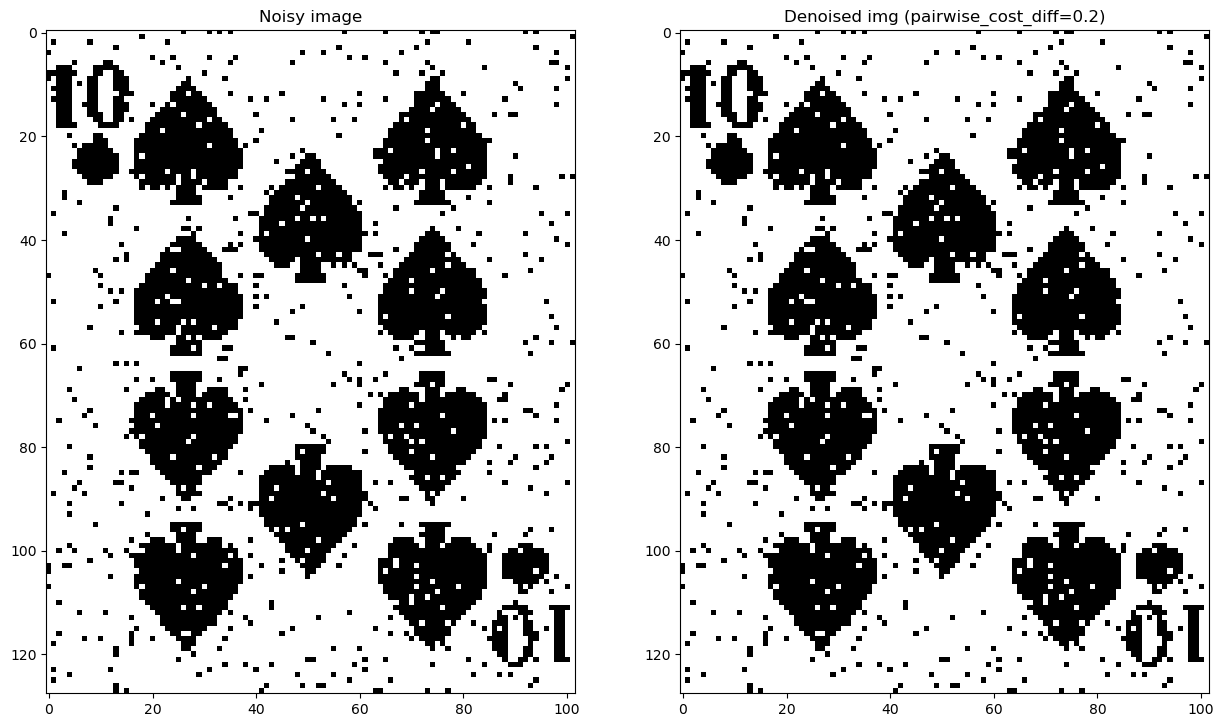

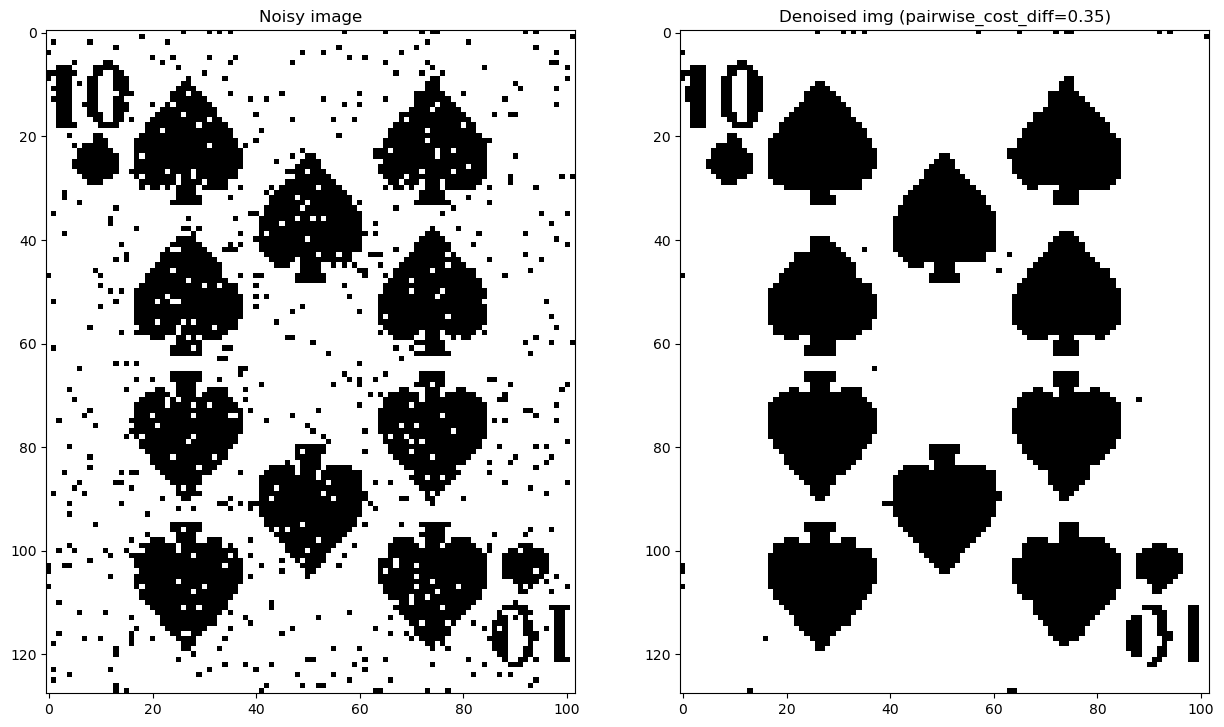

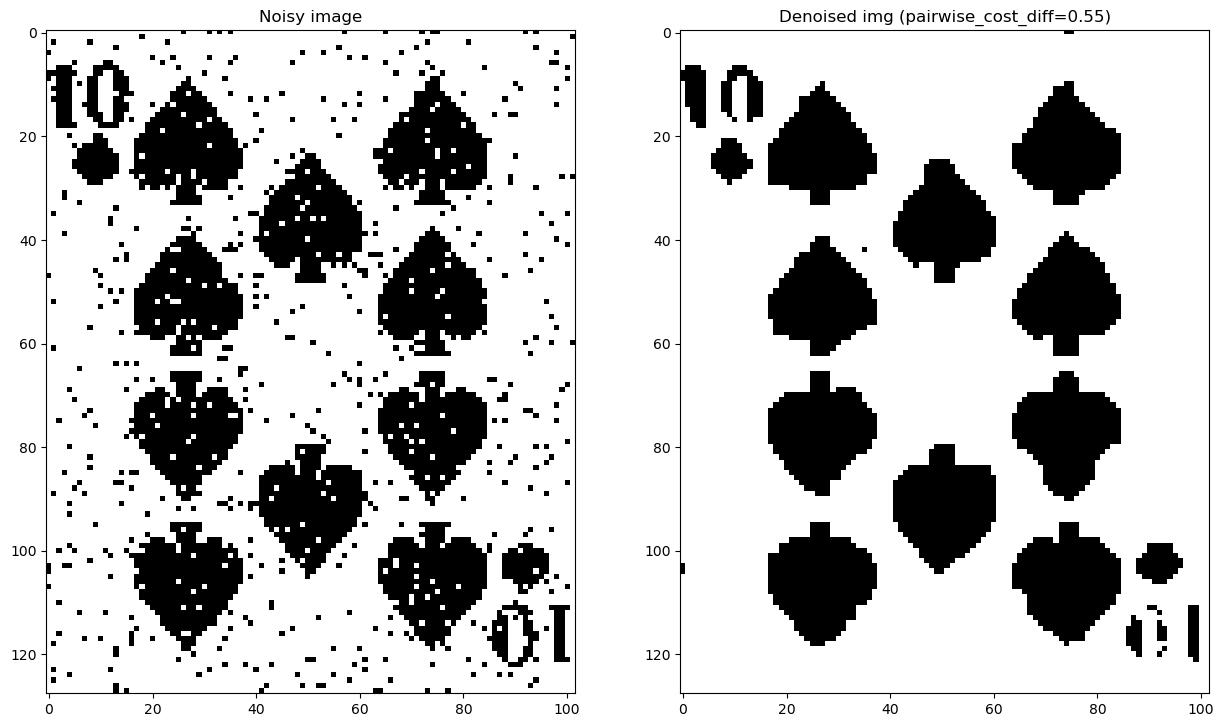

In [5]:
# Call solution for question 3
question_3(noisy_img, rho=0.7, pairwise_cost_same=0.005, pairwise_cost_diff=0.2)
question_3(noisy_img, rho=0.7, pairwise_cost_same=0.005, pairwise_cost_diff=0.35)
question_3(noisy_img, rho=0.7, pairwise_cost_same=0.005, pairwise_cost_diff=0.55)

Seems like pairwise_cost_diff=0.2 has no impact

## Task 4.
 Extend the algorithm in question 3 for a grayscale imagenoise2.png using Alpha Expansion Algorithm. <br> There are only three labels $[l_1, l_2, l_3]$ where $l_1=1$, $l_2=2$ and $l_3=3$ corresponding to gray values of (0,128,255) respectively. <br> Unary costs are defined as:

 $$

 $$

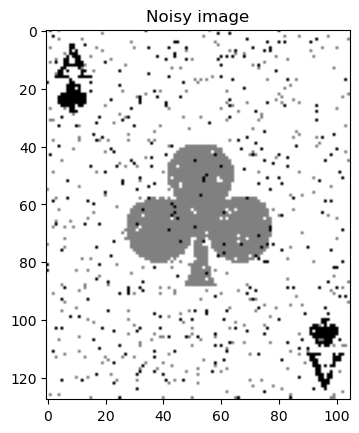

Noisy Img shape: (128, 105)
Noisy Img dtype: uint8


In [6]:
image_q4 = cv.imread('./images/noise2.png', cv.IMREAD_GRAYSCALE)
display_image('Noisy image', image_q4)

print(f"Noisy Img shape: {image_q4.shape}")
print(f"Noisy Img dtype: {image_q4.dtype}")

In [7]:
labels = np.unique(image_q4).tolist()
print(f"The noisy image has pixels with following values: {labels}")

The noisy image has pixels with following values: [0, 128, 255]


Let's normalize image to the range [0,1]

In [8]:
image_q4_float = image_q4.astype(float) / 255
labels_float = np.unique(image_q4_float).tolist()
print(f"The noisy image has pixels with following values: {labels_float}")

The noisy image has pixels with following values: [0.0, 0.5019607843137255, 1.0]


Ok, gray value seems not very nice. It will be easier to work with integers in range [0, 255]

In [9]:
def unary_costs_2(img, rho: float, label_value):
    """
    Computes unary costs for given image for source and sink.
    :param img: image object
    :param rho: rho value
    :return: unary cost matrixes for source and sink
    """
    # find indexes of black, gray and white pixels
    indexes_black = np.where(img == 0)
    indexes_gray = np.where(img == 128)
    indexes_white = np.where(img == 255)
    # init cost matrixes for source and sink
    costs_matrix_source = np.zeros(img.shape)
    costs_matrix_sink = np.zeros(img.shape)

    if(label_value == 0):
        # set costs for black pixels
        costs_matrix_source[indexes_black] = rho
        costs_matrix_sink[indexes_black] = rho
        # set costs for gray pixels
        costs_matrix_source[indexes_gray] = (1 - rho) / 2
        costs_matrix_sink[indexes_gray] = (1 - rho) / 2
        # set costs for white pixels
        costs_matrix_source[indexes_white] = (1 - rho) / 2
        costs_matrix_sink[indexes_white] = (1 - rho) / 2

    elif(label_value == 128):
        # set costs for black pixels
        costs_matrix_source[indexes_black] = (1 - rho) / 2
        costs_matrix_sink[indexes_black] = (1 - rho) / 2
        # set costs for gray pixels
        costs_matrix_source[indexes_gray] = rho
        costs_matrix_sink[indexes_gray] = rho
        # set costs for white pixels
        costs_matrix_source[indexes_white] = (1 - rho) / 2
        costs_matrix_sink[indexes_white] = (1 - rho) / 2
    
    elif(label_value == 255):
        # set costs for black pixels
        costs_matrix_source[indexes_black] = (1 - rho) / 2
        costs_matrix_sink[indexes_black] = (1 - rho) / 2
        # set costs for gray pixels
        costs_matrix_source[indexes_gray] = (1 - rho) / 2
        costs_matrix_sink[indexes_gray] = (1 - rho) / 2
        # set costs for white pixels
        costs_matrix_source[indexes_white] = rho
        costs_matrix_sink[indexes_white] = rho
    
    return -np.log(costs_matrix_source), -np.log(costs_matrix_sink)


def add_pairwise_costs_to_graph(g, nodeids, img, lable_value: int, pairwise_cost_same=0, pairwise_cost_diff=1):
    """
    Adds pairwise costs to the graph.
    :param g: graph object
    :param nodeids: node ids of the graph
    :param img: image object
    :param lable_value: label value [0, 128, 255]
    :param pairwise_cost_same: pairwise cost for pixels with the same label. For Potts model it is 0.
    :param pairwise_cost_diff: pairwise cost for pixels with different labels. For Potts model it is 1.
    """
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            current_pixel = img[i][j]
            neighbours_arr = []
            neighbours_coords = []
            right_neighbour = img[i, j+1] if j+1 < img.shape[1] else None
            bottom_neighbour = img[i+1, j] if i+1 < img.shape[0] else None
            if right_neighbour is not None:
                neighbours_arr.append(right_neighbour)
                neighbours_coords.append([i, j+1])
            if bottom_neighbour is not None:
                neighbours_arr.append(bottom_neighbour)
                neighbours_coords.append([i+1, j])
            
            for l, neighbour in enumerate(neighbours_arr):
                # if current pixel and neighbour have same lable value equal to lable_value
                if current_pixel == lable_value and neighbour == lable_value:
                    g.add_edge(nodeids[i][j], nodeids[neighbours_coords[l][0],neighbours_coords[l][1]], pairwise_cost_same, pairwise_cost_same)
                # if current pixel has lable_value and neighbour has different lable_value
                elif current_pixel == lable_value and neighbour != lable_value:
                    g.add_edge(nodeids[i][j], nodeids[neighbours_coords[l][0],neighbours_coords[l][1]], pairwise_cost_same, pairwise_cost_diff)
                # if current pixel has different lable_value and neighbour has lable_value
                elif current_pixel != lable_value and neighbour == lable_value:
                    g.add_edge(nodeids[i][j], nodeids[neighbours_coords[l][0],neighbours_coords[l][1]], pairwise_cost_diff, pairwise_cost_same)
                # if current pixel and neighbour have same value but different from lable_value
                elif current_pixel != lable_value and neighbour != lable_value and current_pixel == neighbour:
                    g.add_edge(nodeids[i][j], nodeids[neighbours_coords[l][0],neighbours_coords[l][1]], pairwise_cost_diff, pairwise_cost_diff)
                # if current pixel and neighbour have different values and different from lable_value
                else:
                    # we have to add a new node to the graph and connect it with current pixel, neighbour and sink
                    new_node_id = g.add_nodes(1)
                    g.add_edge(nodeids[i][j], new_node_id, pairwise_cost_diff, np.inf)
                    g.add_edge(nodeids[neighbours_coords[l][0]][neighbours_coords[l][1]], new_node_id, pairwise_cost_diff, np.inf)
                    g.add_tedge(new_node_id, 0, pairwise_cost_diff)
                    
    return g


In [10]:
def alpha_expansion(img, rho:float, lable_value:np.int8):
    """
    Alpha expansion algorithm.
    :param img: image object
    :param rho: rho value
    :param lable_value: label value
    :param pairwise_costs: pairwise costs
    :return: segments matrix
    """
    # 1) Define Graph
    g = maxflow.Graph[float]()
    # 2) Add pixels as nodes
    nodeids = g.add_grid_nodes(img.shape)
    # 3) Compute Unary cost
    unary_costs_source, unary_costs_sink = unary_costs_2(img, rho=rho, label_value=lable_value)
    # 4) Add terminal edges
    g.add_grid_tedges(nodeids, unary_costs_source, unary_costs_sink)
    # 5) Add Node edges
    # Alpha expansion needs asymmetric pairwise costs, that's why the solution from previous task can not be used.
    # We have to add the pairwise costs for each pixel separately dependent on lables of its neighbours.
    g = add_pairwise_costs_to_graph(g, nodeids, img, lable_value, pairwise_cost_same=0, pairwise_cost_diff=1)
    # 6) Maxflow
    g.maxflow()
    # 7) Get Segments
    segments = g.get_grid_segments(nodeids)
    
    return segments

In [11]:
def question_4(img, rho=0.05):
    labels = np.unique(img).tolist()
    denoised_img = np.zeros_like(img)
    for label in labels:
        segments = alpha_expansion(img, rho, label)
        segments = np.invert(segments)
        denoised_img[segments] = label
    
    display_image('Denoised image', denoised_img)

    ## Let's compare the result with the original image
    display_image('Original image', img, 'Denoised image', denoised_img)

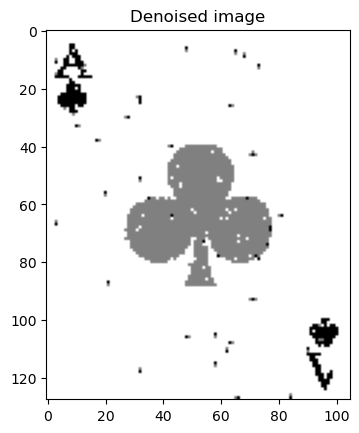

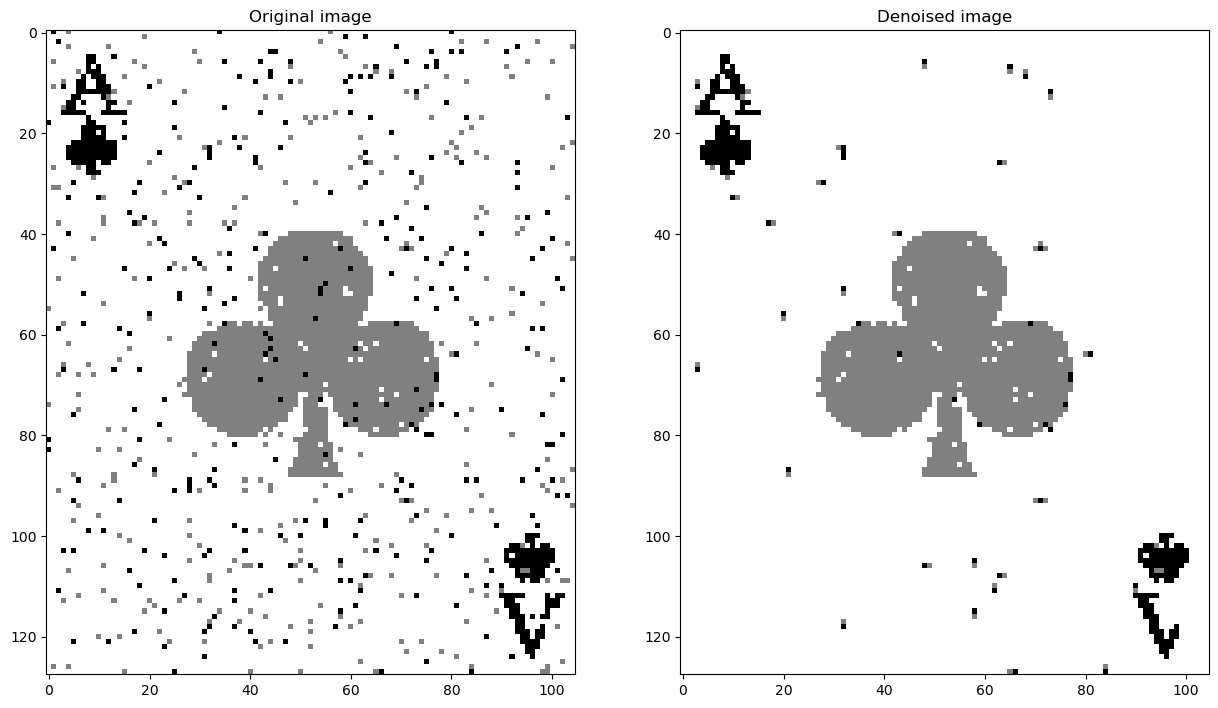

In [12]:
question_4(image_q4, rho=0.04)